In [1]:
from tqdm import tqdm
import jax
import os

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

# jax.print_environment_info()

: 

In [2]:
import jax.numpy as jnp
# from IPython.display import YouTubeVideo

from pmwd import (
    Configuration,
    SimpleLCDM,
    boltzmann,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.vis_util import simshow

In [65]:
from PIL import Image

import matplotlib.pyplot as plt

# Load the image
image_path = 'iss045e066112.jpeg'
image = Image.open(image_path)

# Convert the image to grayscale
image = image.convert('L')

# rotate
ang = -135
image = image.rotate(ang)

# crop the pixture
xmin, ymin = 350, 50
xmax, ymax = xmin+512, ymin+512
image = image.crop((xmin, ymin, xmax, ymax))

# add black space to the edges
targetdim = (640, 640)
new_im = Image.new("L", targetdim)
new_im.paste(image, (64, 64))
image = new_im

# downscale
# targetdim = (32, 32)
targetdim = (64, 64)
image = image.resize(targetdim)

# Convert the image to a numpy array
image = jnp.array(image)

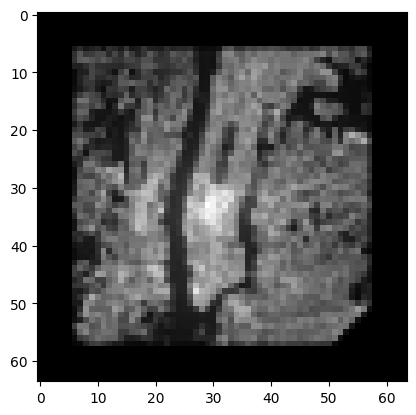

In [66]:
f, ax = plt.subplots()
ax.imshow(image, cmap='gray')
# ax.axis('off')

In [67]:
ptcl_spacing = 10.
ptcl_grid_shape = (*targetdim, 16)
mesh_shape = (*targetdim, 16)

In [68]:
# normalize the image to make the target
im_tgt = image / 255
im_tgt *= jnp.prod(jnp.array(ptcl_grid_shape)) / im_tgt.sum()

In [69]:
from functools import partial

from jax.example_libraries.optimizers import adam


def model(modes, cosmo, conf):
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter_2d(ptcl, conf)
    return dens


def scatter_2d(ptcl, conf):
    dens = jnp.zeros(tuple(s for s in conf.mesh_shape), dtype=conf.float_dtype)
    dens = scatter(ptcl, conf, mesh=dens, val=1, cell_size=conf.cell_size / 2)
    return dens.sum(axis=2)


pmwdshow = partial(simshow, figsize=(27/4, 4), cmap='cividis', colorbar=False)


def obj(tgt, modes, cosmo, conf):
    dens = model(modes, cosmo, conf)
    return (dens - tgt).var() / tgt.var()


obj_valgrad = jax.value_and_grad(obj, argnums=1)


def optim(tgt, modes, cosmo, conf, iters=100, lr=0.1):
    init, update, get_params = adam(lr)
    state = init(modes)

    def step(i, state, tgt, cosmo, conf):
        modes = get_params(state)
        value, grads = obj_valgrad(tgt, modes, cosmo, conf)
        state = update(i, grads, state)
        return value, state

    tgt = jnp.asarray(tgt)
    for i in tqdm(range(iters)):
        value, state = step(i, state, tgt, cosmo, conf)

    modes = get_params(state)
    return value, modes

In [70]:
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape)
cosmo = SimpleLCDM(conf)
seed = 0
modes = white_noise(seed, conf, real=True)
cosmo = boltzmann(cosmo, conf)

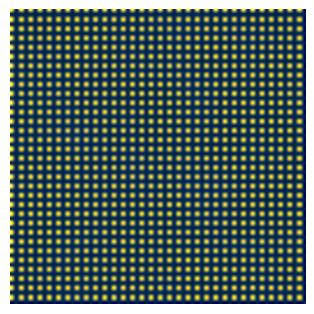

In [71]:
ptcl, obsvbl = lpt(linear_modes(modes, cosmo, conf), cosmo, conf)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

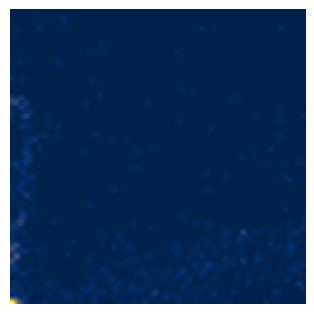

In [73]:
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

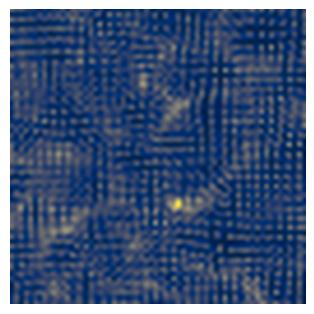

In [74]:
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf, reverse=True)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

In [75]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=1)
loss, modes.std(), modes_optim.std()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.09s/it]


(Array(1.007, dtype=float32),
 Array(1.002, dtype=float32),
 Array(1.007, dtype=float32))

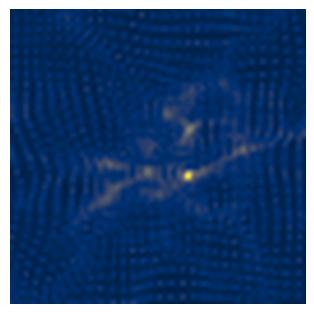

In [76]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

In [77]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=100)
loss, modes.std(), modes_optim.std()

100%|██████████| 100/100 [22:24<00:00, 13.44s/it]


(Array(0.578, dtype=float32),
 Array(1.002, dtype=float32),
 Array(1.115, dtype=float32))

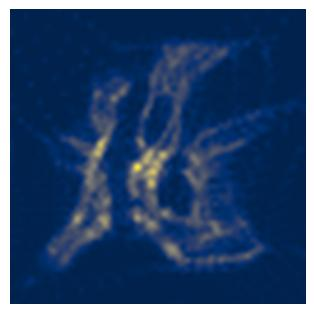

In [78]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

In [ ]:
# ~~~ SET UP IMAGE ~~~
print('Setting up IMAGE...')
# Load the image
image_path = 'iss045e066112.jpeg'
image = Image.open(image_path)

# Convert the image to grayscale
image = image.convert('L')

# rotate
ang = -135
image = image.rotate(ang)

# pad black space around the edges
pad = 64
image = Image.new("L", (image.width+2*pad, image.height+2*pad), color=0)
image.paste(image, (pad, pad))

# crop the picture
xmin, ymin = 350, 50
xmax, ymax = xmin+512, ymin+512
image = image.crop((xmin, ymin, xmax, ymax))

# # add black space to the edges
# targetdim = (640, 640)
# new_im = Image.new("L", targetdim)
# new_im.paste(image, (64, 64))
# image = new_im

# downscale
image = image.resize(targetdim)

# Convert the image to a numpy array
image = jnp.array(image)

# Save the outputs
f, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.axis('off')
# f.savefig(join(odir, 'truth.jpg'), bbox_inches='tight', pad_inches=0)
# plt.close(f)